In [ ]:
from asbe.base import *
from asbe.models import *
from asbe.estimators import *
from econml.orf import DMLOrthoForest
from econml.dml import CausalForestDML
from causalml.inference.nn import CEVAE
from openbt.openbt import OPENBT
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from copy import deepcopy
import econml
from causalml.dataset import synthetic_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
def prepare_data(number, random_state):
    df = pd.read_csv(
    f"https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{number}.csv",
    names = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{x}' for x in range(25)])
    X = df.loc[:,"x0":].to_numpy()
    t = df["treatment"].to_numpy()
    #t = np.zeros_like(t)
    y = df["y_factual"].to_numpy()
    y1 = np.where(df["treatment"] == 1,
                   df['y_factual'],
                   df['y_cfactual'])
    y0 = np.where(df["treatment"] == 0,
                   df['y_factual'],
                   df['y_cfactual'])
    ite = np.where(df["treatment"] == 1,
                   df['y_factual'] - df["y_cfactual"],
                   df['y_cfactual'] - df["y_factual"])
    X_train, X_test, t_train, t_test, y_train, y_test, ite_train, ite_test, y1_train, y1_test, y0_train, y0_test = train_test_split(
    X, t, y, ite, y1, y0,  test_size=0.865, random_state=random_state)
    ds = {"X_training": X_train,
     "y_training": y_train,
     "t_training": t_train,
     "X_pool": X_test[:400, :], 
     "y_pool": y_test[:400],
     "t_pool": t_test[:400],
     "y1_pool": y1_test[:400],
     "y0_pool": y0_test[:400],
     "X_test": X_test[:400, :],
     "y_test": y_test[400:],
     "t_test": t_test[400:],
      "ite_test": ite_test[:400]
     }
    return ds

In [ ]:
res = {}
for i in range(20):
    for d in range(9):
        ds = prepare_data(d+1, i)
        asl = BaseActiveLearner(estimator = GPEstimator(model = GaussianProcessRegressor(ConstantKernel()*RBF(np.ones(ds["X_training"].shape[1],))),
                                                 two_model=True,
                                                            ps_model=None),
                                acquisition_function=[RandomAcquisitionFunction(name="random"),
                                                      UncertaintyAcquisitionFunction(name="unc"),
                                                      TypeSAcquistionFunction(name="type_s"),
                                                      EMCMAcquisitionFunction(name="emcm")],
                                assignment_function=BaseAssignmentFunction(),
                                stopping_function = None,
                                dataset=ds,
                               al_steps=5)
        _ = asl.simulate(no_query=1, metric="decision")
        res[f"{i}_{d}"] =  pd.DataFrame(asl.simulation_results)
        res[f"{i}_{d}"]["sim"] = i
        res[f"{i}_{d}"]["data"] = d

In [ ]:
resdf = pd.concat(res.values())

In [ ]:
resdf.reset_index(inplace=True)

In [ ]:
print(resdf.groupby(["data", "index"])["random_1", "unc_1", "type_s_1", "emcm_1"].mean().loc[0].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  random\_1 &     unc\_1 &  type\_s\_1 &    emcm\_1 \\
index &           &           &           &           \\
\midrule
1     &  0.613125 &  0.613125 &  0.613125 &  0.613125 \\
2     &  0.615250 &  0.615375 &  0.609500 &  0.609750 \\
3     &  0.591750 &  0.607250 &  0.602000 &  0.597500 \\
4     &  0.585750 &  0.582750 &  0.586750 &  0.589750 \\
5     &  0.613000 &  0.619250 &  0.599500 &  0.612500 \\
\bottomrule
\end{tabular}



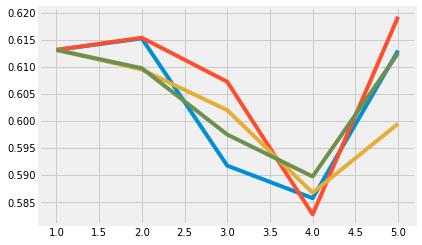

In [ ]:
plt.plot(resdf.groupby(["data", "index"])["random_1", "unc_1", "type_s_1", "emcm_1"].mean().loc[0])

In [ ]:
import matplotlib.pyplot as plt